# Mycological Machine Learning
---

## Introduction

### Background

Every year thousands of people are sickened and in some cases die as the result of consuming poisonous mushrooms [<sup>1</sup>](#fn1). While foraging for mushrooms is a fun activity and a great way to learn about the natural world, one must be cautious about consuming wild mushrooms. The key to the safe consumption of wild mushrooms is correctly identifying the mushroom species. However, mycologists estimate that there are over 10,000 different species of mushrooms on the planet [<sup>2</sup>](#fn2). As a result, identifying the correct mushroom can be difficult--especially to the untrained eye. One way to help mushroom foragers correctly identify whether a mushroom is poisonous or not is to use a trained machine learning model to make accurate predictions.

### Solution

The UCI Machine Learning Repository features a mushroom dataset [<sup>3</sup>](#fn3) that can be used to train a model to predict poisonous mushrooms based on various mushroom characteristics. The data is taken from the Audobon Society Field Guide, and it features 22 features and 1 class of poisonous or edible. In order to help prevent mushroom foragers from mistakenly eating poisonous mushrooms, I will train a classification model on the UCI mushroom dataset. Once the model is trained I will deploy it via AWS Sagemaker. Then I will build a web app where users will be able to enter various characteristics of a mushroom, and the model will predict whether it thinks the mushroom is poisonous or not.

### Metrics

Precision and recall are the most important evaluation metrics that I will consider. However, recall will be the key metric since I want to ensure that all “positive” or poisonous mushrooms are actually labeled as poisonous. Still, I want to be careful to not have a low precision either. Therefore, I will compute the predictions’ F1 score to determine the “harmonic mean of precision and recall” [<sup>4</sup>](#fn4).

---

## Data Exploration

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()

role = get_execution_role()

In [3]:
# Load the dataset

def load_mushroom_data():
    csv_path = os.path.join("data", "mushrooms.csv")
    return pd.read_csv(csv_path)

In [4]:
mushrooms = load_mushroom_data()
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


The above CSV rows show that the data is all textual, including the class. As part of the data preprocessing step, I will convert the data to numerical values.

### Attribute Information:

1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
4. bruises?: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

The Attritbute Information guide is a helpful reference since many of the features are coded similarly.

In [5]:
mushrooms.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


When working with numerical values the the `describe` method can be useful to understand some helpful statistics about the data. Since this datset only features text the statistics aren't that useful. Still, I wanted to use this method to see if anything interesting popped out.

## Data Visualization

Text(0.5, 1.0, 'Count of Poisonous and Edible Classes')

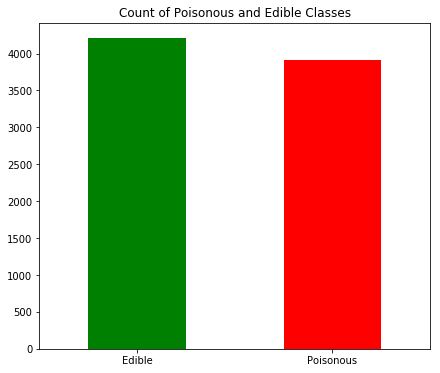

In [6]:
# I used the following resources to build the bar graphs
# https://dfrieds.com/data-visualizations/bar-plot-python-pandas
# https://stackoverflow.com/questions/51536617/how-rename-pd-value-counts-index-with-a-correspondance-dictionary

class_dict = { "e":"Edible", "p":"Poisonous" }
class_graph = mushrooms["class"].value_counts().rename(index=class_dict).plot(kind='bar', figsize=(7, 6), rot=0, color=['green', 'red'])
plt.title("Count of Poisonous and Edible Classes")

The above graph shows that the 2 classes appear relatively evenly throughout the dataset. An imbalanced dataset can be difficult to work with. If the classes aren't represented equally in the data, then the model may have a hard time accurately predicting both classes. Another issue is that the model's accuracy ends up being high--but it's high only because the majority of the represented classes are all the same. Fortunately, the mushroom dataset is balanced, so I don't have to worry about collecting more data to get an accuracte representation.

In [7]:
# The following graphs will compare the features of the poisonous and edible classes,
# so I create 2 dataframes--one for each class

p_class_df = mushrooms.loc[mushrooms['class'] == 'p'] 
e_class_df = mushrooms.loc[mushrooms['class'] == 'e'] 

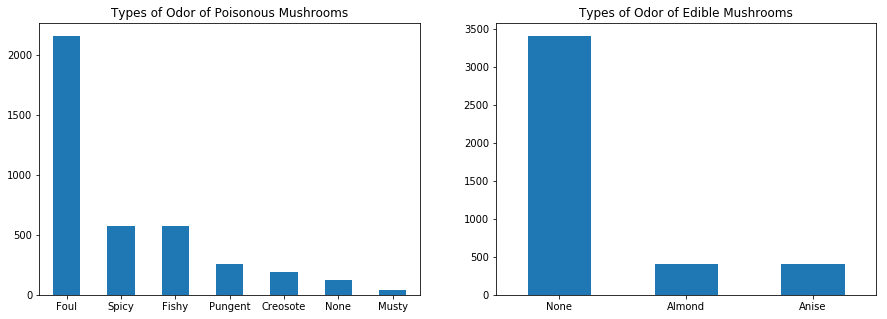

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

odor_dict = {"f": "Foul", "s": "Spicy", "y": "Fishy", "p": "Pungent", 
             "c": "Creosote", "n": "None", "m": "Musty", "a": "Almond", 
             "l": "Anise"}

ax_0 = p_class_df["odor"].value_counts().rename(index=odor_dict).plot(kind='bar', rot=0, ax=ax[0])
ax_0.set_title("Types of Odor of Poisonous Mushrooms")
ax_0

ax_1 = e_class_df["odor"].value_counts().rename(index=odor_dict).plot(kind='bar', rot=0, ax=ax[1])
ax_1.set_title("Types of Odor of Edible Mushrooms")
ax_1

It's interesting to note that poisonous mushrooms have more variety of odors than edible mushrooms. The only odor the 2 classes share is "none." Edible mushrooms overwhelmingly lack an odor while many poisonous mushrooms have a foul smell.

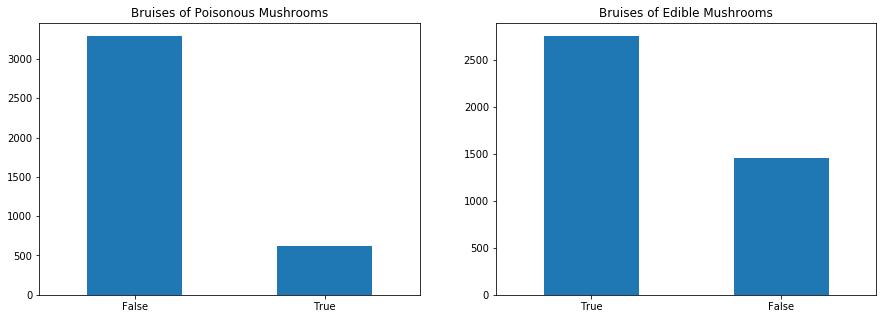

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

bruises_dict = {"t": "True", "f": "False"}

ax_0 = p_class_df["bruises"].value_counts().rename(index=bruises_dict).plot(kind='bar', rot=0, ax=ax[0])
ax_0.set_title("Bruises of Poisonous Mushrooms")
ax_0

ax_1 = e_class_df["bruises"].value_counts().rename(index=bruises_dict).plot(kind='bar', rot=0, ax=ax[1])
ax_1.set_title("Bruises of Edible Mushrooms")
ax_1

Sometimes when a mushroom is handled it develops bruises--discoloration where it has been touched or at its broken stem after being picked. Edible mushrooms typically display bruises, while poisonous mushrooms don't.

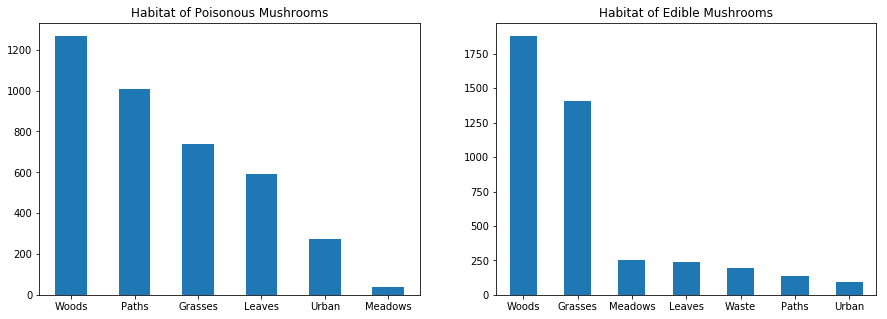

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

habitat_dict = {"g": "Grasses", "l": "Leaves", "m": "Meadows", 
                "p": "Paths", "u": "Urban", "w": "Waste", "d": "Woods"}

ax_0 = p_class_df["habitat"].value_counts().rename(index=habitat_dict).plot(kind='bar', rot=0, ax=ax[0])
ax_0.set_title("Habitat of Poisonous Mushrooms")
ax_0

ax_1 = e_class_df["habitat"].value_counts().rename(index=habitat_dict).plot(kind='bar', rot=0, ax=ax[1])
ax_1.set_title("Habitat of Edible Mushrooms")
ax_1

Both poisonous and edible mushrooms are most commonly found in the woods. The above graphs make it clear that both classes of mushrooms share the same environments; however, edible mushrooms are more commonly found in "waste" habitats--unlike poisonous mushrooms.

## Data Preprocessing

In [11]:
# Check for missing data
mushrooms.isnull().values.any()

False

The dataset contains no missing values which makes preprocessing easier.

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

mushrooms_preprocessed = mushrooms

le = LabelEncoder()
mushrooms_preprocessed["class"] = le.fit_transform(mushrooms_preprocessed["class"])
mushroom_classes_df = pd.DataFrame(mushrooms_preprocessed["class"].values)

one_hot = OneHotEncoder()
mushroom_features = one_hot.fit_transform(mushrooms_preprocessed.drop("class", axis=1)).toarray()
mushroom_features_df = pd.DataFrame(mushroom_features)

In [13]:
mushroom_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
mushroom_classes_df.head()

,0
0,1
1,0
2,0
3,1
4,0


First, the class is converted to either 0 or 1 with sklearn's `LabelEncoder`. I plan to use Sagemaker's Linear Learner algorithm to train a model, and the Linear Learner docs state, "For binary classification problems, the label must be either 0 or 1." [<sup>6</sup>](#fn6) Then I convert the data features to one hot vectors with sklearn's `OneHotEncoder`.

## 

In [15]:
from sklearn.model_selection import train_test_split

y = mushroom_classes_df
X = mushroom_features_df
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In the above code block I split up the data into training and test sets. Below I save the training and test data locally and then upload it to S3 so that the model can access it during training.

In [16]:
X_test.to_csv(os.path.join("data", 'test.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join("data", 'train.csv'), header=False, index=False)

In [17]:
prefix = "mushrooms-linear-learner"

test_location = session.upload_data(os.path.join("data", "test.csv"), key_prefix=prefix)
train_location = session.upload_data(os.path.join("data", "train.csv"), key_prefix=prefix)

## Model Benchmark

On Kaggle, there is a kernel titled Mushroom Classification [<sup>5</sup>](#fn5) that compares the precision and recall of seven different models trained on the dataset. The highest average precision and recall that any of the models achieve on the test data is 93 percent. (SVC, K-NN, and Random Forest each achieve 93 percent.) Therefore, I will train my model with the goal of achieving a benchmark average total of at least 90 percent precision and recall on the test data, and I will compare my trained model to the three aforementioned benchmark models.

## Train the model

Since the dataset only contains 2 different classes, I will train a binary classifer. I have decided to use Sagemaker's built-in Linear Learner algorithm to train my model. The Sagemaker docs state "Linear models are supervised learning algorithms used for solving either classification or regression problems,"[<sup>6</sup>](#fn6) so the Linear Learner algorithm will be a good fit for this classification problem. Plus, I am curious to see how a built-in Sagemaker model performs compared to the benchmark models I have selected. I will start by training the model for the highest recall since I want to limit the number of false negatives.

### Train for the Highest Recall

In [18]:
container = get_image_uri(session.boto_region_name, 'linear-learner')

linear_learner = sagemaker.estimator.Estimator(container,
                                               role,
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                               sagemaker_session=session)

# In order to train for the highest recall, 
# I pass the 'recall_at_target_precision' argument to the linear learner.
# I also specify the number of features my data has, and the predictor type.
# Due to the one hot encoding, the number of features increased from 22 to 117

linear_learner.set_hyperparameters(feature_dim=117,
                                   predictor_type='binary_classifier',
                                   binary_classifier_model_selection_criteria='recall_at_target_precision')

In [19]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')

linear_learner.fit({'train': s3_input_train })

2019-11-06 00:26:34 Starting - Starting the training job......
2019-11-06 00:27:19 Starting - Launching requested ML instances......
2019-11-06 00:28:24 Starting - Preparing the instances for training......
2019-11-06 00:29:25 Downloading - Downloading input data...
2019-11-06 00:30:03 Training - Downloading the training image...
2019-11-06 00:30:31 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
[11/06/2019 00:30:23 INFO 140361482327872] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_met


2019-11-06 00:30:38 Completed - Training job completed
Training seconds: 73
Billable seconds: 73


### Deploy and Evaluate the Recall Model

In [20]:
linear_predictor = linear_learner.deploy(initial_instance_count=1,
                                         instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------------------!

In [21]:
# I used the below link to determine the type of serializer, deserializer, and content_type to use:
# https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/linear_learner_mnist/linear_learner_mnist.ipynb

from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [22]:
# Print the prediction of a single answer
y_pred = linear_predictor.predict(X_test.values[0])
print(Y_test.values[0])
print(y_pred['predictions'][0]['predicted_label'])

[0]
0.0


In [23]:
# Generate an array of all of the predicted values. Again, I referred to the below resource:
# https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/linear_learner_mnist/linear_learner_mnist.ipynb

predictions = []
for array in X_test.values:
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)
predictions

array([0., 1., 1., ..., 1., 0., 0.])

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predictions)

0.876538146021329

88% isn't that good of an accuracy score, so some refinement will likely be necessary.

In [25]:
from sklearn.metrics import f1_score
f1_score(Y_test, predictions, average='macro')  

0.8754775615839153

As I mentioned in my introduction, the F1 score will help determine the balance between the model's precision and recall. The closer the score is to 1 the more balance there is between the two metrics. The F1 score is lower than I would like, so I will tweak some of the model's parameters and retrain.

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(Y_test,predictions)

confusion_matrix

array([[ 956,  301],
       [   0, 1181]])

The confusion matrix shows that there are 0 false negatives, meaning 0 of the poisonous mushrooms have been marked as edible. This is great, but 301 edible mushrooms have been marked as poisonous. If my only goal is to ensure that no poisonous mushrooms are misidentified, then this model accomplishes that task. However, I will retrain the model to see what other results I can achieve.

### Train for the Highest Precision

In [ ]:
# First, delete the existing endpoint

linear_predictor.delete_endpoint()

In [61]:
container = get_image_uri(session.boto_region_name, 'linear-learner')

linear_learner = sagemaker.estimator.Estimator(container,
                                               role,
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                               sagemaker_session=session)

# I pass the 'precision_at_target_recall' argument to the linear learner.

linear_learner.set_hyperparameters(feature_dim=117,
                                   predictor_type='binary_classifier',
                                   binary_classifier_model_selection_criteria='precision_at_target_recall')

In [62]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')

linear_learner.fit({'train': s3_input_train })

2019-10-22 22:18:06 Starting - Starting the training job...
2019-10-22 22:18:07 Starting - Launching requested ML instances......
2019-10-22 22:19:09 Starting - Preparing the instances for training...
2019-10-22 22:20:00 Downloading - Downloading input data...
2019-10-22 22:20:36 Training - Downloading the training image...
2019-10-22 22:21:04 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
[10/22/2019 22:20:56 INFO 140340638029632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma'


2019-10-22 22:21:11 Completed - Training job completed
Training seconds: 71
Billable seconds: 71


### Deploy and Evaluate the Precision Model

In [23]:
linear_predictor = linear_learner.deploy(initial_instance_count=1,
                                         instance_type='ml.m4.xlarge')


# If you create the endpoint via the sagemaker dashboard you can pass in the endpoint name as the first argument
# Then you can use linear_predictor to make predictions

# linear_predictor = sagemaker.predictor.RealTimePredictor('precision', 
#                                                          sagemaker_session=session)

In [24]:
# https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/linear_learner_mnist/linear_learner_mnist.ipynb

from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [26]:
predictions = []
for array in X_test.values:
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)
predictions

array([0., 1., 1., ..., 1., 0., 0.])

In [27]:
# Compare the predictions to the actual values and compute the precision score

from sklearn.metrics import precision_score
precision_score(Y_test, predictions)

1.0

The model has a precision score of 100%. Not bad!

In [77]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predictions)

0.958086367485182

The precision model has a much higher accuracy score--96% vs the recall model's 88%.

In [70]:
from sklearn.metrics import f1_score
f1_score(Y_test, predictions, average='macro')  

0.9591826380859563

An F1 score of 96% means the model's precision and recall are quite balanced. Plus, this score beats the benchmark model's F1 score.

In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(Y_test,predictions)

confusion_matrix

array([[1257,    0],
       [  99, 1082]])

The confustion matrix shows that 0 edible mushrooms have been marked as poisonous. However, 99 poisonous mushrooms have been marked as edible! Although the model has a high F1 score and 100% precision, 99 poisonous mushrooms being marked as edible is concerning. Therefore, I am going to retrain the model one final time to see if I can lower the number of false negatives.

### Train for the Highest F1 Score

In [ ]:
# First, delete the existing endpoint

linear_predictor.delete_endpoint()

In [18]:
container = get_image_uri(session.boto_region_name, 'linear-learner')

linear_learner = sagemaker.estimator.Estimator(container,
                                               role,
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                               sagemaker_session=session)

# Remove the 'precision_at_target_recall' argument. 
# When no binary_classifier_model_selection_criteria argument is used
# the model trains for the highest f1 score by default.

linear_learner.set_hyperparameters(feature_dim=117,
                                   predictor_type='binary_classifier')

In [19]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')

linear_learner.fit({'train': s3_input_train })

2019-10-29 11:15:35 Starting - Starting the training job...
2019-10-29 11:15:45 Starting - Launching requested ML instances......
2019-10-29 11:17:03 Starting - Preparing the instances for training......
2019-10-29 11:17:46 Downloading - Downloading input data...
2019-10-29 11:18:24 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[10/29/2019 11:18:46 INFO 139868470073152] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall':


2019-10-29 11:19:01 Uploading - Uploading generated training model
2019-10-29 11:19:01 Completed - Training job completed
[10/29/2019 11:18:51 INFO 139868470073152] #train_score (algo-1) : ('binary_classification_cross_entropy_objective', 0.0034614137851810356)
[10/29/2019 11:18:51 INFO 139868470073152] #train_score (algo-1) : ('binary_classification_accuracy', 0.9982412944073162)
[10/29/2019 11:18:51 INFO 139868470073152] #train_score (algo-1) : ('binary_f_1.000', 0.9981684981684982)
[10/29/2019 11:18:51 INFO 139868470073152] #train_score (algo-1) : ('precision', 1.0)
[10/29/2019 11:18:51 INFO 139868470073152] #train_score (algo-1) : ('recall', 0.9963436928702011)
[10/29/2019 11:18:51 INFO 139868470073152] #quality_metric: host=algo-1, train binary_classification_cross_entropy_objective <loss>=0.00346141378518
[10/29/2019 11:18:51 INFO 139868470073152] #quality_metric: host=algo-1, train binary_classification_accuracy <score>=0.998241294407
[10/29/2019 11:18:51 INFO 139868470073152] 

### Deploy and Evaluate the F1 model

In [23]:
linear_predictor = linear_learner.deploy(initial_instance_count=1,
                                         instance_type='ml.m4.xlarge')

# linear_predictor = sagemaker.predictor.RealTimePredictor('f1score', 
#                                                          sagemaker_session=session)

In [24]:
# https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/linear_learner_mnist/linear_learner_mnist.ipynb

from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [25]:
# Generate an array of all of the predicted values.

predictions = []
for array in X_test.values:
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)
predictions

array([0., 1., 1., ..., 1., 0., 0.])

In [26]:
# Compare the predictions to the actual values and compute the precision score

from sklearn.metrics import precision_score
precision_score(Y_test, predictions)

1.0

The retrained model still has a precision of 100%.

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predictions)

0.9967186218211649

The F1 score model has the highest accuracy of the 3 models.

In [27]:
from sklearn.metrics import f1_score
f1_score(Y_test, predictions, average='macro')  

0.9967147218327486

The retrained model's F1 score is much better; it's almost perfectly balanced. 

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix=confusion_matrix(Y_test,predictions)

confusion_matrix

array([[1257,    0],
       [   8, 1173]])

After retraining the model the resulting confusion matrix shows a much lower amount of false negatives--a reduction of 93%. However, there are still 8 false negatives. Overall, I am satisfied with the model's results when training for recall and training for the F1 score. While training specifically for recall does lower the model's precision, the model won't recommend that a poisonous mushroom is safe to eat. Therefore, if I had to use one of these models in production, I would use the recall model. When only considering metrics--and not whether the model will be used in production--the F1 model's results do much better than the benchmark models. Overall, I am happy with Linear Learner when compared to the benchmark models, but I would want to train a different algorithm to use in production. My goal would still be to train for the highest recall, but I would still like to see 0 false negatives.

## Set up AWS Lambda and API Gateway

I will use the F1 trained model to build a web app that generates predictions for users. Step 7 of [Creating a Sentiment Analysis Web App Notebook](https://github.com/udacity/sagemaker-deployment/blob/master/Project/SageMaker%20Project.ipynb) will walk you through how to set up AWS Lambda and API Gateway for the app. However, for the lambda function you can use the following code:

```python

import boto3
import numpy as np
import json

def lambda_handler(event, context):

    runtime = boto3.Session().client('sagemaker-runtime')
    
    # I used the following resource to create the vector and body variables:
    # https://stackoverflow.com/questions/53770876/aws-sagemaker-invokeendpoint-operation-model-error-setting-an-array-element
    
    vector = np.array(json.loads(event['body']))
   
    body = ','.join([str(item) for item in vector])
    
    # Replace EndpointName with the name of your deployed endpoint
    response = runtime.invoke_endpoint(EndpointName = 'YOUR-ENDPOINT-NAME',
                                       ContentType = 'text/csv',
                                       Body = body)
                                                                                    
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }

```

In order to use numpy in the lamdba function, you have to add the AWSLambda-Python36-SciPy1x layer to your function:
- Within your function select Layers. 
- Scroll down until you see the Add a Layer button. 
- Click Add a Layer and select AWSLambda-Python36-SciPy1x from the Name dropdown. 
- Select the available Version and click Add.

## Web App

Now that Lambda and API Gateway are set up clone the Django [web app](https://github.com/Pat878/mushroom-project) I created and follow the README instructions to connect the API to the app. You will need the API URL that was created when you set up API Gateway. The web app will allow you to select different mushroom features via a form. The submitted data is preprocessed and sent to the deployed endpoint. Then the predicted value of edible or poisonous is returned to the app.

In [34]:
# If you are not going to set up the web app, delete the endpoint

linear_predictor.delete_endpoint()

## Conclusion

The results of the trained Linear Learner model satisfactorily solve the issue of determining whether a mushroom is poisonous or not. My main concern with training the model was achieving a balance between precision and recall, and I ended up with an F1 score of nearly 100 when training for the highest F1 score. I wasn't happy with the initial model's confusion matrix, but after tweaking the model's parameters and retraining for precision I got much better results. However, since a poisonous mushroom can be lethal, any number of false negatives is unacceptable. This means that the model that was trained for the highest precision isn't useful--even though it had a relatively high F1 score. Training for the highest recall had an even worse F1 score, but at least there weren't any false negatives. When I retrained the model with the goal of achieving the highest F1 score, I lowered the number of false negatives considerably and achieved the highest F1 score. 

While this model performs better than the benchmark model I would be hesitant to use it in production. Since my ultimate goal is to correctly identify all poisonous mushrooms, out of the three trained models I would use the recall model for production. It misidentifies a considerable amount of edible mushrooms, but users won't die from following its advice. Still, I would prefer to train other models to see if a better F1 score--with no false negatives--could be achieved. Then I would have a better idea of which model to use in a production setting.

## Notes

1. <span id="fn1">http://eattheplanet.org/foraging-fatality-statistics-2016/</span>
2. <span id="fn2">https://www.mushroom-appreciation.com/types-of-mushrooms.html</span>
3. <span id="fn3">https://archive.ics.uci.edu/ml/datasets/mushroom
4. <span id="fn4">https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
5. <span id="fn5">https://www.kaggle.com/raghuchaudhary/mushroom-classification
6. <span id="fn6">https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html